# Hyperparameter Tuning

| Method                                  | Description                                                           | Pros                           | Cons                         |
| --------------------------------------- | --------------------------------------------------------------------- | ------------------------------ | ---------------------------- |
| **Grid Search**                         | Tries **every combination** of specified values                       | Simple, exhaustive             | Expensive if grid is large   |
| **Random Search**                       | Tries **random combinations** from a range                            | Faster with large spaces       | May miss optimal region      |
| **Manual Search**                       | You change values by hand and observe performance                     | Flexible, intuitive            | Time-consuming, inconsistent |
| **Bayesian Optimization**               | Models performance as a probability distribution and explores smartly | Efficient for expensive models | More complex to implement    |
| **Cross-validation + any of the above** | Evaluate each setting more reliably using folds                       | Reduces overfitting risk       | Slower but safer             |


| Scenario                             | Recommended Method               |
| ------------------------------------ | -------------------------------- |
| Small, interpretable parameter space | Grid search                      |
| Large space, limited time            | Random search                    |
| Expensive models or many parameters  | Bayesian optimization            |
| You're learning or experimenting     | Manual tuning + cross-validation |


| Type                       | Examples                                                        | Use for                      |
| -------------------------- | --------------------------------------------------------------- | ---------------------------- |
| **Regression metrics**     | `'r2'`, `'neg_mean_squared_error'`, `'neg_mean_absolute_error'` | Predicting continuous values |
| **Classification metrics** | `'accuracy'`, `'f1'`, `'roc_auc'`, `'precision'`, `'recall'`    | Predicting categories        |


| `scoring` value                 | What it measures                     | Higher is better?         | Notes                                     |
| ------------------------------- | ------------------------------------ | ------------------------- | ----------------------------------------- |
| `'r2'`                          | R-squared score (explained variance) | ✅ Yes                     | Most intuitive for regression             |
| `'neg_mean_squared_error'`      | Negative MSE                         | ✅ Less negative is better | You need to **negate** it to get real MSE |
| `'neg_mean_absolute_error'`     | Negative MAE                         | ✅ Less negative is better | Less sensitive to outliers                |
| `'neg_root_mean_squared_error'` | Negative RMSE                        | ✅ Less negative is better | Square root of MSE                        |


| Goal                                       | Use                             |
| ------------------------------------------ | ------------------------------- |
| Want interpretable % of variance explained | `'r2'`                          |
| Want to punish large errors                | `'neg_mean_squared_error'`      |
| Care about average error size              | `'neg_mean_absolute_error'`     |
| Want error in same unit as target          | `'neg_root_mean_squared_error'` |


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Load dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target


In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
# Define alpha search space
alpha_space = np.logspace(-3, 2, 30)
param_grid = {'alpha': alpha_space}

In [15]:
# -------------------------
# 1 Grid Search
# -------------------------
print("\nGridSearchCV")
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)
print("Best alpha (Grid):", ridge_grid.best_params_['alpha'])
print("Best CV R² (Grid):", ridge_grid.best_score_)


GridSearchCV
Best alpha (Grid): 0.001
Best CV R² (Grid): 0.607159968412593


In [18]:
# -------------------------
# 2 Random Search
# -------------------------
print("\n RandomizedSearchCV")
ridge_random = RandomizedSearchCV(Ridge(), param_distributions=param_grid, n_iter=10, cv=5, scoring='r2', random_state=42)
ridge_random.fit(X_train, y_train)
print("Best alpha (Random):", ridge_random.best_params_['alpha'])
print("Best CV R² (Random):", ridge_random.best_score_)



 RandomizedSearchCV
Best alpha (Random): 0.001
Best CV R² (Random): 0.607159968412593


In [19]:
# -------------------------
# Evaluate both on test set
# -------------------------
print("\n Test Set Evaluation")
for label, model in zip(["Grid", "Random"], [ridge_grid.best_estimator_, ridge_random.best_estimator_]):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{label} Search → R²: {r2:.4f}, MSE: {mse:.4f}")



 Test Set Evaluation
Grid Search → R²: 0.5911, MSE: 0.5411
Random Search → R²: 0.5911, MSE: 0.5411


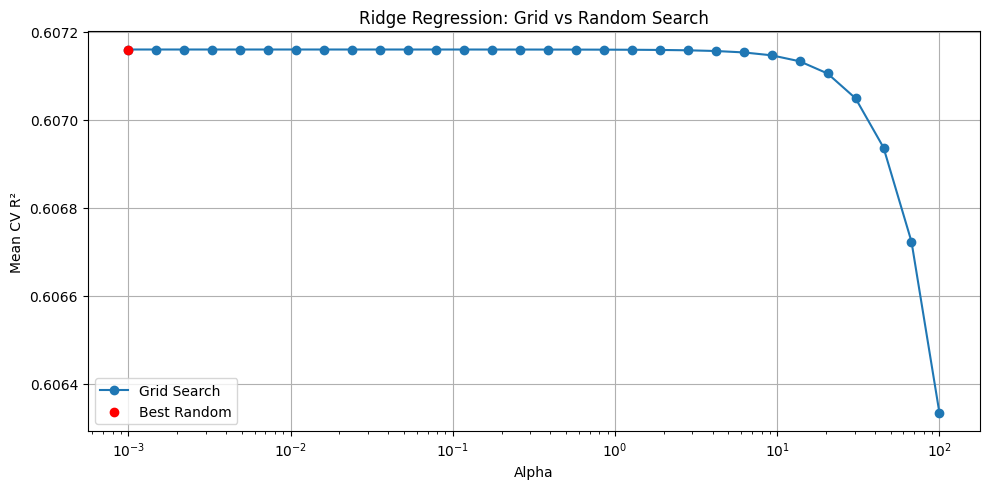

In [20]:
# -------------------------
# Plot tuning curves
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(alpha_space, ridge_grid.cv_results_['mean_test_score'], label='Grid Search', marker='o')
plt.scatter(ridge_random.best_params_['alpha'], ridge_random.best_score_, color='red', label='Best Random', zorder=5)
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Mean CV R²")
plt.title("Ridge Regression: Grid vs Random Search")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
